In [1]:
  from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import re
import os
import ast
import cv2
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from mpl_toolkits.mplot3d import Axes3D
from datetime import date
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p,inv_boxcox1p,boxcox
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder,StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from collections import defaultdict
import xgboost as xgb
import lightgbm as lgb
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5);
sns.set_style('whitegrid')

In [ ]:
# https://www.kaggle.com/mobasshir/recommendation-engine

In [3]:
with open('/content/drive/My Drive/Colab/Bil573/VariableDefinitions.txt') as f:
    print(f.read())

﻿Train Customers


Information on the customers in the training set. 


'akeed_customer_id': Unique customer ID, used in train_locations and train_orders
'gender': Customer gender
'dob': Birth Year (if entered)
'status' and 'verified': Account status
'language': Chosen language
'Created_at' and 'updated_at': dates when account was created/updated


Train Locations


Each customer orders from one or more locations. Each is assigned a location number. 
'customer_id': The unique customer ID 
'location_number': Location number (most customers have one or two)
'location_type': Home, Work, Other or NA
'Latitude' and 'longitude': Not true latitude and longitude - locations have been masked, but nearby locations remain nearby in the new reference frame and can thus be used for clustering. However, not all locations are useful due to GPS errors and missing data - you may want to treat outliers separately.


Train Orders


This is a record of all orders made by customers in the train set from th

# TRAIN_FULL

In [4]:
train_full = pd.read_csv("/content/drive/My Drive/Colab/Bil573/train_full.csv")
nRow, nCol = train_full.shape
print(f'There are {nRow} rows and {nCol} columns')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 5802400 rows and 73 columns


In [5]:
train_full.dropna(subset=['latitude_x'], inplace=True)
train_full.dropna(subset=['longitude_x'], inplace=True)
train_full.dropna(subset=['device_type'], inplace=True)
train_full.dropna(subset=['display_orders'], inplace=True)
train_full.dropna(subset=['location_number_obj'], inplace=True)
train_full.dropna(subset=['id_obj'], inplace=True)
train_full.dropna(subset=['target'], inplace=True)

In [6]:
train_full.loc[train_full["location_type"].isna(), 'location_type'] = 0
train_full.loc[train_full["location_type"]=="Home", 'location_type'] = 1
train_full.loc[train_full["location_type"]=="Work", 'location_type'] = 2
train_full.loc[train_full["location_type"]=="Other", 'location_type'] = 3

In [7]:
train_full.loc[train_full["gender"].isna(), 'gender'] = 0
train_full.loc[train_full["gender"]=="Male", 'gender'] = 1
train_full.loc[train_full["gender"]=="Female", 'gender'] = 2

In [8]:
train_full.loc[train_full["vendor_category_id"]==2, 'vendor_category_id'] = 0
train_full.loc[train_full["vendor_category_id"]==3, 'vendor_category_id'] = 1

In [9]:
train_full["vendor_rating"] = train_full["vendor_rating"] - 3.8

In [10]:
train_full=train_full[train_full['is_open']!=0]

In [11]:
features_to_drop=["created_at_x", "updated_at_x", "authentication_id", "vendor_category_en", "is_open", "OpeningTime", "OpeningTime2", "sunday_from_time1", "sunday_to_time1",
                  "sunday_from_time2", "sunday_to_time2", "monday_from_time1", "monday_to_time1", "monday_from_time2", "monday_to_time2", "tuesday_from_time1",
                  "tuesday_to_time1", "tuesday_from_time2", "tuesday_to_time2", "wednesday_from_time1", "wednesday_to_time1", "wednesday_from_time2",
                  "wednesday_to_time2", "thursday_from_time1", "thursday_to_time1", "thursday_from_time2", "thursday_to_time2", "friday_from_time1",
                  "friday_to_time1", "friday_from_time2", "friday_to_time2", "saturday_from_time1", "saturday_to_time1", "saturday_from_time2", "saturday_to_time2",
                  "commission", "is_akeed_delivering", "status_y", "verified_y", "language", "primary_tags", "open_close_flags", "vendor_tag", "vendor_tag_name",
                  "one_click_vendor", "country_id", "city_id", "created_at_y", "updated_at_y", "display_orders", "CID X LOC_NUM X VENDOR"]

for feature in features_to_drop:
  train_full=train_full.drop([feature],axis=1)

In [12]:
train_full['target'].value_counts()

0    4863748
1      67782
Name: target, dtype: int64

In [13]:
train_full['target'].isna().sum()

0

In [14]:
train_full.isna().sum().sum()

0

In [15]:
train_full.shape

(4931530, 22)

In [16]:
train_full.head(3)

,customer_id,gender,status_x,verified_x,location_number,location_type,latitude_x,longitude_x,id,latitude_y,longitude_y,vendor_category_id,delivery_charge,serving_distance,prepration_time,discount_percentage,rank,vendor_rating,device_type,location_number_obj,id_obj,target
0,TCHWPBT,1,1,1,0,2,-96.44,-67.2,4,-0.5884,0.7544,0.0,0.0,6.0,15,0.0,11,0.6,3,0,4,0
1,TCHWPBT,1,1,1,0,2,-96.44,-67.2,13,-0.4717,0.7446,0.0,0.7,5.0,14,0.0,11,0.9,3,0,13,0
2,TCHWPBT,1,1,1,0,2,-96.44,-67.2,20,-0.4075,0.6436,0.0,0.0,8.0,19,0.0,1,0.7,3,0,20,0


In [17]:
train_full.describe()

,status_x,verified_x,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,vendor_category_id,delivery_charge,serving_distance,prepration_time,discount_percentage,rank,vendor_rating,device_type,location_number_obj,id_obj,target
count,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06,4.931530e+06
mean,9.991727e-01,9.715261e-01,7.501120e-01,2.355730e+00,-2.515269e+01,3.011529e+02,2.263520e+00,8.948918e-01,9.411765e-02,3.870588e-01,1.141176e+01,1.360000e+01,1.294118e+00,9.705882e+00,5.811765e-01,2.976471e+00,7.501120e-01,3.011529e+02,1.374462e-02
std,2.875144e-02,1.663225e-01,1.329800e+00,2.276045e+01,3.695347e+01,2.553900e+02,2.220222e+01,4.739869e+00,2.919924e-01,3.480326e-01,4.246228e+00,2.987031e+00,6.780290e+00,3.356552e+00,2.089155e-01,2.156506e-01,1.329800e+00,2.553900e+02,1.164290e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.038000e+03,-1.344000e+02,4.000000e+00,-1.588000e+00,-1.449000e+00,0.000000e+00,0.000000e+00,2.000000e+00,5.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,0.000000e+00,-5.034000e-01,-7.850000e+01,9.200000e+01,-7.120000e-01,8.770000e-02,0.000000e+00,0.000000e+00,8.000000e+00,1.000000e+01,0.000000e+00,1.100000e+01,4.000000e-01,3.000000e+00,0.000000e+00,9.200000e+01,0.000000e+00
50%,1.000000e+00,1.000000e+00,0.000000e+00,-8.826000e-02,2.106500e-02,2.070000e+02,-4.922000e-01,5.273000e-01,0.000000e+00,7.000000e-01,1.500000e+01,1.500000e+01,0.000000e+00,1.100000e+01,6.000000e-01,3.000000e+00,0.000000e+00,2.070000e+02,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,2.610000e-01,5.130000e-01,4.010000e+02,5.750000e-03,6.560000e-01,0.000000e+00,7.000000e-01,1.500000e+01,1.500000e+01,0.000000e+00,1.100000e+01,7.000000e-01,3.000000e+00,1.000000e+00,4.010000e+02,0.000000e+00
max,1.000000e+00,1.000000e+00,2.900000e+01,4.538000e+02,4.534000e+01,9.070000e+02,2.052000e+02,4.422000e+01,1.000000e+00,7.000000e-01,1.500000e+01,2.100000e+01,5.000000e+01,1.100000e+01,1.000000e+00,3.000000e+00,2.900000e+01,9.070000e+02,1.000000e+00


# PREPARE DATASET

In [ ]:
# train full
# train test ayır
# label 0 1

In [ ]:
# Customer için
# Girdiyi restaurantlara böl
# her birini yüzde 70 olasılıkla trainigne 30 ile teste at

In [ ]:
train_df.columns

In [ ]:
explicit_df = df[['customer_id','id','restaurent_rating']]
explicit_df.columns = ['customer_id','restaurent_id','restaurent_rating']

In [ ]:
explicit_df.shape

In [ ]:
explicit_df.info()

In [ ]:
print('Dataset shape: {}'.format(explicit_df.shape))
print('-Dataset examples-')
print(explicit_df.iloc[::20000, :])

In [ ]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = explicit_df['restaurent_rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / explicit_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(explicit_df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [ ]:
# Number of ratings per book
data = explicit_df.groupby('restaurent_id')['restaurent_rating'].count().clip(upper=100)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 100,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Restaurent (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per Restaurent'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [ ]:
explicit_df.groupby('restaurent_id')['restaurent_rating'].count().reset_index().sort_values('restaurent_rating', ascending=False)[:10]

In [ ]:
# Number of ratings per user
data = explicit_df.groupby('customer_id')['restaurent_rating'].count().clip(upper=100)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 100,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 100)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [ ]:
explicit_df.groupby('customer_id')['restaurent_rating'].count().reset_index().sort_values('restaurent_rating', ascending=False)[:10]

# VISUALIZE DATASET

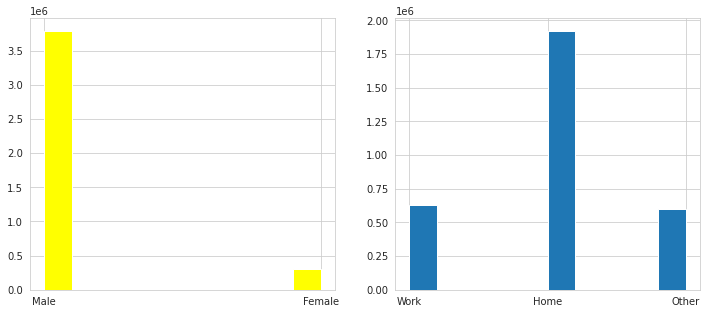

In [ ]:
# BURAYI DUZELT
fig, ax = plt.subplots(1, 2)
train_full['gender'].hist(ax=ax[0], color='yellow')
train_full['location_type'].hist(ax=ax[1])

In [ ]:
train_full['discount_percentage'].value_counts()

0.0     5570304
50.0      58024
35.0      58024
15.0      58024
10.0      58024
Name: discount_percentage, dtype: int64

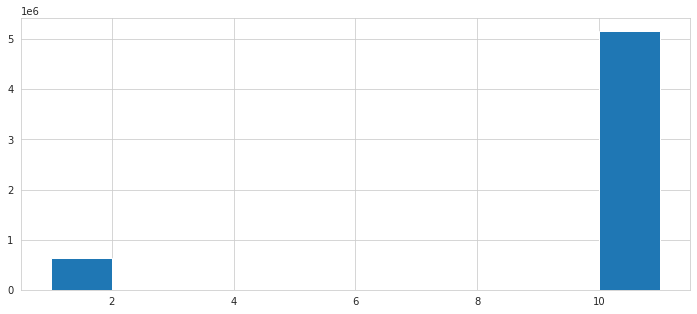

In [ ]:
train_full['rank'].hist()

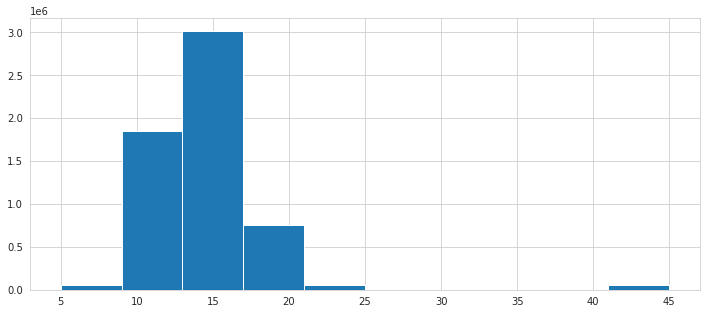

In [ ]:
train_full['prepration_time'].hist()

In [ ]:
explicit_df.restaurent_rating.unique()

In [ ]:
df = explicit_df

In [ ]:
in_ratings = 5
filter_items = df['restaurent_id'].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 5
filter_users = df['customer_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['restaurent_id'].isin(filter_items)) & (df['customer_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new[['customer_id', 'restaurent_id', 'restaurent_rating']], reader)

In [ ]:
benchmark = []

algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

# FEATURE ENGINEERING

# TRAINING

In [ ]:
# softmax kullan
# 2li sınıflandırma
# Bu kullanıcı bu restauranı sever mi
# Belli yakınlıktakiler için yüzde bul

In [ ]:
# LightGBM
# KNN
# SVD
# K-means
# Random Tree
# Random Forest

# TEST

# ESKİ KODLAR

In [ ]:
test.index=test.index+3000
df=pd.concat([train.drop("revenue",axis=1),test]).drop("id", axis=1) #drop id
y_train=train["revenue"]
df.shape

(7398, 21)

In [ ]:
def visualize_distribution(y):
    sns.distplot(y,fit=norm)
    mu,sigma=norm.fit(y)
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of revenue")
    plt.ylabel("Frequency")
    plt.show()
    
def visualize_probplot(y):
    stats.probplot(y,plot=plt)
    plt.show()

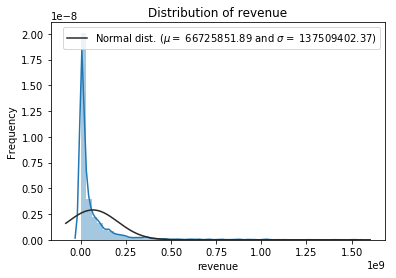

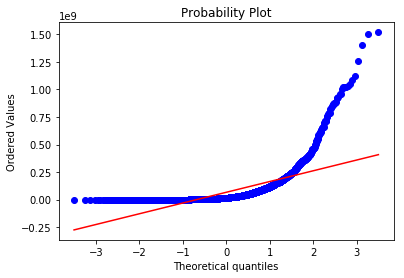

In [ ]:
visualize_distribution(y_train)
visualize_probplot(y_train)

##### We want our model to perform as good as possible and in order to do so the target variable of y_train must be as close as possible to the normal distribution (and its probability plot as close as linear as possible

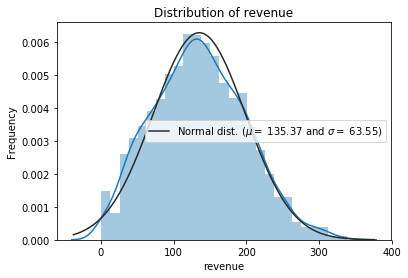

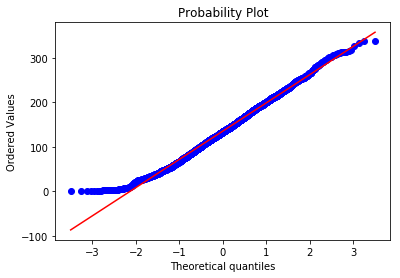

In [ ]:
# boxcox transformation with coefficient 0.2 makes the probability plot closer to linear
y_train=boxcox1p(y_train,0.2)
visualize_distribution(y_train)
visualize_probplot(y_train)

### Fix Features

In [ ]:
features_to_fix=["belongs_to_collection", "genres", "production_companies", "production_countries",\
                 "Keywords"]

for feature in features_to_fix:
    df.loc[df[feature].notnull(),feature]=df.loc[df[feature].notnull(),feature].apply(lambda x : ast.literal_eval(x)).apply(lambda x : [y["name"] for y in x])

df.loc[df["cast"].notnull(),"cast"]=df.loc[df["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
df.loc[df["crew"].notnull(),"crew"]=df.loc[df["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))

### create new features

In [ ]:
df["cast_len"] = df.loc[df["cast"].notnull(),"cast"].apply(lambda x : len(x))
df["crew_len"] = df.loc[df["crew"].notnull(),"crew"].apply(lambda x : len(x))

lbl=LabelEncoder()
lbl.fit(df["release_year"].values)
df["release_year"]=lbl.transform(df["release_year"].values)

### Modify cast and crew

In [ ]:
# For each film we only want to consider the six most important actors
# order is the order of importance in ascending order starting from 0
df.loc[df["cast"].notnull(),"cast"]=df.loc[df["cast"].notnull(),"cast"].apply(lambda x : [y["name"] for y in x if y["order"]<6])

In [ ]:
df["Director"]=[[] for i in range(df.shape[0])]
df["Producer"]=[[] for i in range(df.shape[0])]
df["Executive Producer"]=[[] for i in range(df.shape[0])]

df["Director"]=df.loc[df["crew"].notnull(),"crew"].apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])
df["Producer"]=df.loc[df["crew"].notnull(),"crew"].apply(lambda x : [y["name"] for y in x if y["job"]=="Producer"])
df["Executive Producer"]=df.loc[df["crew"].notnull(),"crew"].apply(lambda x : [y["name"] for y in x if y["job"]=="Executive Producer"])

### delete useless features 

In [ ]:
df=df.drop(["imdb_id","original_title","overview","poster_path","tagline","status","title","spoken_languages","release_date","crew"],axis=1)

### Handle missing values

In [ ]:
mis_val=((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)
mis_val=mis_val.drop(mis_val[mis_val==0].index)
mis_val

belongs_to_collection       79.981076
tagline_word_count          19.735064
Keywords                     9.042985
Keywords_len                 9.042985
production_companies         5.596107
production_companies_len     5.596107
production_countries         2.122195
production_countries_len     2.122195
crew_len                     0.513652
Producer                     0.513652
Executive Producer           0.513652
Director                     0.513652
cast_len                     0.351446
cast                         0.351446
genres                       0.310895
genres_len                   0.310895
overview_word_count          0.297378
runtime                      0.081103
title_word_count             0.040552
release_year                 0.013517
release_month                0.013517
release_day                  0.013517
release_wd                   0.013517
release_quarter              0.013517
dtype: float64

In [ ]:
# missing values will be replaced with empty lists
to_empty_list=["belongs_to_collection","Keywords","production_companies","production_countries",\
              "Director","Producer","Executive Producer","cast","genres"]

for feature in to_empty_list:
    df[feature] = df[feature].apply(lambda d: d if isinstance(d, list) else [])

In [ ]:
# The missing values of time and length will be replaced with 0
to_zero=["runtime","release_month","release_year","release_wd","release_quarter","release_day"]+\
["Keywords_len","production_companies_len","production_countries_len","crew_len","cast_len","genres_len",
    "tagline_word_count","overview_word_count","title_word_count"]

for feat in to_zero:
    df[feat]=df[feat].fillna(0)

In [ ]:
# add new features
df['_budget_popularity_ratio'] = df['budget']/df['popularity']
df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
df['_releaseYear_budget_ratio'] = df['release_year']/df['budget']
df['_releaseYear_budget_ratio2'] = df['budget']/df['release_year']

In [ ]:
mis_val=((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)
mis_val=mis_val.drop(mis_val[mis_val==0].index)
mis_val

_releaseYear_budget_ratio2    0.013517
_releaseYear_budget_ratio     0.013517
dtype: float64

### modify the numeric features in order to make them as close as possible to the normal distribution

In [ ]:
numeric=[feat for feat in df.columns if df[feat].dtype!="object"]

skewness=df[numeric].apply(lambda x : skew(x)).sort_values(ascending=False)
skew=skewness[skewness>2.5]
skew

C:\Users\asus\Anaconda3\lib\site-packages\scipy\stats\stats.py:943: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


_budget_popularity_ratio         85.779254
_releaseYear_popularity_ratio    60.793692
popularity                       19.960329
Keywords_len                      3.123832
production_countries_len          2.990402
budget                            2.891855
cast_len                          2.809725
dtype: float64

In [ ]:
# reduce the skewness of these features by applying a power transformation
high_skew=skew[skew>10].index
medium_skew=skew[skew<=10].index

for feat in high_skew:
    df[feat]=np.log1p(df[feat])

for feat in medium_skew:
    df[feat]=df[feat]=boxcox1p(df[feat],0.15)

skew=df[skew.index].skew()
skew

_budget_popularity_ratio        -0.881118
_releaseYear_popularity_ratio    2.603714
popularity                      -0.437615
Keywords_len                    -0.309683
production_countries_len         1.332405
budget                          -0.476944
cast_len                         0.220478
dtype: float64

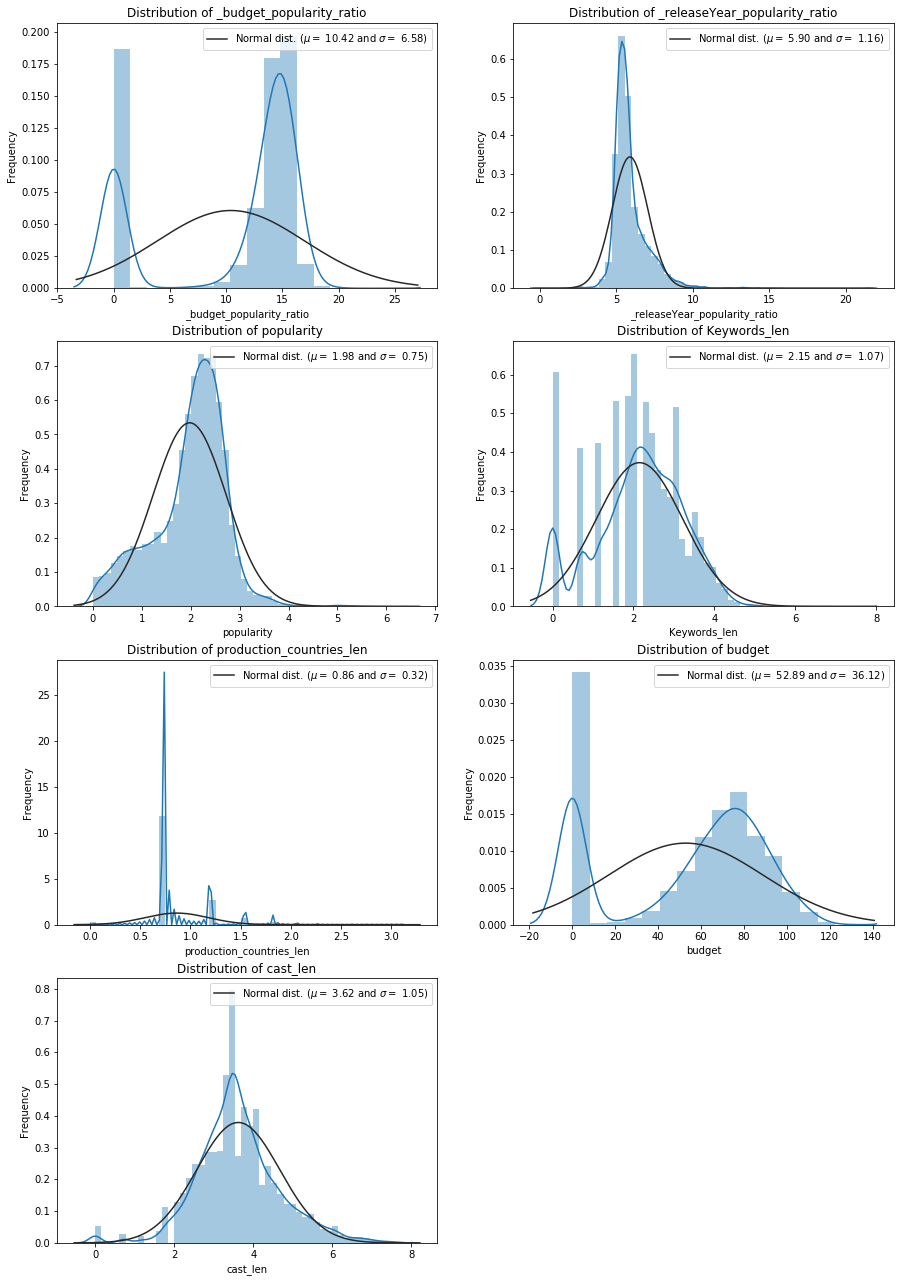

In [ ]:
plt.figure(figsize=(15,40))
for i,feat in enumerate(skew.index):
    plt.subplot(7,2,i+1)
    sns.distplot(df[feat],fit=norm)
    mu,sigma=norm.fit(df[feat])
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of "+feat)
    plt.ylabel("Frequency")
plt.show()

In [ ]:
lbl=LabelEncoder()
lbl.fit(df["release_year"].values)
df["release_year"]=lbl.transform(df["release_year"].values)

In [ ]:
to_dummy = ["belongs_to_collection","genres","original_language","production_companies","production_countries",\
           "Keywords","cast","Director","Producer","Executive Producer"]

In [ ]:
limits=[4,0,0,35,10,40,10,5,10,12] 

for i,feat in enumerate(to_dummy):
    mlb = MultiLabelBinarizer()
    s=df[feat]
    x=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
    y=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index).sum().sort_values(ascending=False)
    rare_entries=y[y<=limits[i]].index
    x=x.drop(rare_entries,axis=1)
    df=df.drop(feat,axis=1)
    df=pd.concat([df, x], axis=1, sort=False)


In [ ]:
ntrain=train.shape[0]

train=df.iloc[:ntrain,:]
test=df.iloc[ntrain:,:]
test.shape

(4398, 1573)

# train

In [ ]:
model_xgb=xgb.XGBRegressor(max_depth=5,
                           learning_rate=0.1, 
                           n_estimators=2000, 
                           objective='reg:linear', 
                           gamma=1.45, 
                           verbosity=3,
                           subsample=0.7, 
                           colsample_bytree=0.8, 
                           colsample_bylevel=0.50)

In [ ]:
model_lgb=lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="rmse", 
                             num_leaves=20, 
                             min_child_samples=100,
                             learning_rate=0.01, 
                             bagging_fraction=0.8, 
                             feature_fraction=0.8, 
                             bagging_frequency=1, 
                             subsample=.9, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [ ]:
model_cat = cat.CatBoostRegressor(iterations=10000,learning_rate=0.01,depth=5,eval_metric='RMSE',\
                              colsample_bylevel=0.7,
                              bagging_temperature = 0.2,
                              metric_period = None,
                              early_stopping_rounds=200)

In [ ]:
def cross_val(model):
    cr_val=np.sqrt(-cross_val_score(model,train.values,y_train.values,scoring="neg_mean_squared_log_error",cv=5))
    return cr_val

In [ ]:
def msle(y,y_pred):
    return np.sqrt(mean_squared_log_error(y,y_pred))

In [ ]:
ti=time.time()
model_lgb.fit(train.values,y_train)
print("Number of minutes of training of model_lgb = {:.2f}".format((time.time()-ti)/60))

lgb_pred_train=model_lgb.predict(train.values)
print("Mean square logarithmic error of lgb model on whole train = {:.4f}".format(msle(y_train,lgb_pred_train)))

Number of minutes of training of model_lgb = 0.21
Mean square logarithmic error of lgb model on whole train = 0.2023


In [ ]:
ti=time.time()
model_xgb.fit(train.values,y_train)
print("Number of minutes of training of model_xgb = {:.2f}".format((time.time()-ti)/60))

xgb_pred_train=model_xgb.predict(train.values)
print("Mean square logarithmic error of xgb model on whole train = {:.4f}".format(msle(y_train,xgb_pred_train)))

C:\Users\asus\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Number of minutes of training of model_xgb = 4.48
Mean square logarithmic error of xgb model on whole train = 0.0958


In [ ]:
ti=time.time()
model_cat.fit(train.values,y_train,verbose=False)
print("Number of minutes of training of model_cal = {:.2f}".format((time.time()-ti)/60))

cat_pred_train=model_cat.predict(train.values)
cat_pred_train[cat_pred_train<0]=0
print("Mean square logarithmic error of cat model on whole train = {:.4f}".format(msle(y_train,cat_pred_train)))

Number of minutes of training of model_cal = 9.14
Mean square logarithmic error of cat model on whole train = 0.4133


In [ ]:
c = np.array([0.333334,0.333333,0.333333])

train_pred=xgb_pred_train*c[0]+lgb_pred_train*c[1]+cat_pred_train*c[2]
print("Mean square logarithmic error of chosen model on whole train = {:.4f}".format(msle(y_train,train_pred)))

Mean square logarithmic error of chosen model on whole train = 0.2659


# test

In [ ]:
lgb_pred=model_lgb.predict(test)
xgb_pred=model_xgb.predict(test.values)
cat_pred=model_cat.predict(test)

In [ ]:
# apply the inverse of the tranformation we applied on y_train
pred=inv_boxcox1p((xgb_pred*c[0]+lgb_pred*c[1]+cat_pred*c[2]),0.2)

sub=pd.DataFrame({"id":np.arange(test.shape[0])+3001,"revenue":pred})
sub.to_csv("my_submission.csv",index=False)

# INTERNETTEN ALINANLAR

In [ ]:
def dataframe_split_between_null_and_not_null(df):
    not_null_df = df.dropna()
    null_df = df.drop(not_null_df.index)
    percentage = 100 * null_df.shape[0] / df.shape[0]
    print("Actual dataset ", df.shape)
    print("Null dataset ", null_df.shape)
    print("Not null dataset ", not_null_df.shape)
    print(f'Null percentage {percentage}%')
    return df, null_df, not_null_df,percentage

In [ ]:
def column_missing_state(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0].sort_values(1, ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table.shape[0]) +
              " columns that have missing values.")
    return mis_val_table

# https://www.kaggle.com/erelin6613/pyspark-alternating-least-squares-in-action

# TRAIN_CUSTOMERS

In [ ]:
train_customers = pd.read_csv("/content/drive/My Drive/Colab/Bil573/train_customers.csv")
nRow, nCol = train_customers.shape
print(f'There are {nRow} rows and {nCol} columns')
train_customers.head(3)

There are 34674 rows and 8 columns


,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42


In [ ]:
def calc_age(year):
    if len(str(year))==2:
        if str(year).startswith('0'):
            year = '20'+str(year)
        else:
            year = '19'+str(year)
        year = int(year)
    if year is None:
        return np.nan
    return 2020-year

train_customers.loc[:, 'age'] = train_customers['dob'].apply(calc_age)
train_customers[train_customers['age']<16]

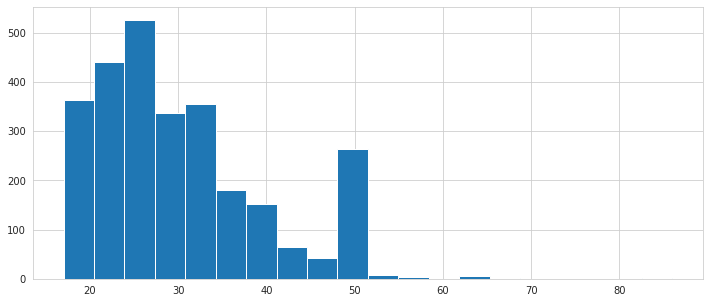

In [ ]:
ages = train_customers[train_customers['age']>16]
ages = ages[ages['age']<110]
ages['age'].dropna().hist(bins=20, label='customers by age')